In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(style='darkgrid')
palette = 'mako'
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

In [2]:
df = pd.read_pickle('../datasets/processed.pkl')
df.head()

,data,consumo_energia,corrente_atrasada,corrente_principal,co2,potência_atrasado,potência_principal,segundos_depois_meia_noite,estado_semana,dia_semana,tipo_carga
0,2018-01-01 00:15:00,3.17,2.95,0.0,0.0,73.21,100.0,900,Dia da Semana,Segunda-feira,Carga leve
1,2018-01-01 00:30:00,4.00,4.46,0.0,0.0,66.77,100.0,1800,Dia da Semana,Segunda-feira,Carga leve
2,2018-01-01 00:45:00,3.24,3.28,0.0,0.0,70.28,100.0,2700,Dia da Semana,Segunda-feira,Carga leve
3,2018-01-01 01:00:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Dia da Semana,Segunda-feira,Carga leve
4,2018-01-01 01:15:00,3.82,4.50,0.0,0.0,64.72,100.0,4500,Dia da Semana,Segunda-feira,Carga leve


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   data                        35040 non-null  datetime64[ns]
 1   consumo_energia             35040 non-null  float64       
 2   corrente_atrasada           35040 non-null  float64       
 3   corrente_principal          35040 non-null  float64       
 4   co2                         35040 non-null  float32       
 5   potência_atrasado           35040 non-null  float64       
 6   potência_principal          35040 non-null  float64       
 7   segundos_depois_meia_noite  35040 non-null  int32         
 8   estado_semana               35040 non-null  category      
 9   dia_semana                  35040 non-null  category      
 10  tipo_carga                  35040 non-null  category      
dtypes: category(3), datetime64[ns](1), float32(1), float64

In [4]:
df.describe().T.drop('count', axis=1)

,mean,std,min,25%,50%,75%,max
consumo_energia,27.386892,33.444380,0.0,3.20,4.57,51.2375,157.18
corrente_atrasada,13.035384,16.306000,0.0,2.30,5.00,22.6400,96.91
corrente_principal,3.870949,7.424463,0.0,0.00,0.00,2.0900,27.76
co2,0.011524,0.016151,0.0,0.00,0.00,0.0200,0.07
potência_atrasado,80.578056,18.921322,0.0,63.32,87.96,99.0225,100.00
potência_principal,84.367870,30.456535,0.0,99.70,100.00,100.0000,100.00
segundos_depois_meia_noite,42750.000000,24940.534317,0.0,21375.00,42750.00,64125.0000,85500.00


In [5]:
df.describe(exclude=[np.number, np.datetime64]).T.drop('count', axis=1)

,unique,top,freq
estado_semana,2,Dia da Semana,25056
dia_semana,7,Segunda-feira,5088
tipo_carga,3,Carga leve,18072


- [Verão: 21 dezembro, às (14h28) de 2017 a 20 de março de 2018 (13h14);](https://www.gov.br/observatorio/pt-br/assuntos/noticias/verao-2017-comeca-no-dia-21-de-dezembro-as-14h28)
- [Verão: de 21 de dezembro (20h22) a 20 de março de 2019 (18h58);](https://www.gov.br/observatorio/pt-br/assuntos/noticias/verao-2018)
- [Outono: de 20 de março (13h14) a 21 de junho de 2018 (7h07);](https://www.gov.br/observatorio/pt-br/assuntos/noticias/outono-2018-comeca-no-proximo-dia-20)
- [Inverno: de 21 de junho (7h07) a 22 de setembro de 2018 (22h53);](https://www.gov.br/observatorio/pt-br/assuntos/noticias/solsticio-inverno-2018)
- [Primavera: de 22 de setembro (22h53) a 21 de dezembro de 2018 (20h22).](https://www.gov.br/observatorio/pt-br/assuntos/noticias/primavera-2018)

In [6]:
def estacao_do_ano(data):
    verao_2018_inicio = pd.Timestamp('2017-12-21 14:28:00')
    verao_2018_fim = pd.Timestamp('2018-03-20 13:14:00')
    verao_2019_inicio = pd.Timestamp('2018-12-21 20:22:00')
    verao_2019_fim = pd.Timestamp('2019-03-20 18:58:00')
    outono_inicio = pd.Timestamp('2018-03-20 13:14:00')
    outono_fim = pd.Timestamp('2018-06-21 07:07:00')
    inverno_inicio = pd.Timestamp('2018-06-21 07:07:00')
    inverno_fim = pd.Timestamp('2018-09-22 22:53:00')
    primavera_inicio = pd.Timestamp('2018-09-22 22:53:00')
    primavera_fim = pd.Timestamp('2018-12-21 20:22:00')
    
    if verao_2018_inicio <= data < verao_2018_fim or verao_2019_inicio <= data < verao_2019_fim:
        return 'Verão'
    elif outono_inicio <= data < outono_fim:
        return 'Outono'
    elif inverno_inicio <= data < inverno_fim:
        return 'Inverno'
    elif primavera_inicio <= data < primavera_fim:
        return 'Primavera'
    else:
        return 'Fora do intervalo'

df['estacao'] = df['data'].apply(estacao_do_ano)

In [7]:
df.sort_values('consumo_energia', ascending=True).head(10)

,data,consumo_energia,corrente_atrasada,corrente_principal,co2,potência_atrasado,potência_principal,segundos_depois_meia_noite,estado_semana,dia_semana,tipo_carga,estacao
29855,2018-07-11 00:00:00,0.00,0.00,0.0,0.0,0.00,0.0,0,Dia da Semana,Quarta-feira,Carga leve,Inverno
25848,2018-09-27 06:15:00,2.45,4.93,0.0,0.0,44.50,100.0,22500,Dia da Semana,Quinta-feira,Carga leve,Primavera
25847,2018-09-27 06:00:00,2.45,4.97,0.0,0.0,44.22,100.0,21600,Dia da Semana,Quinta-feira,Carga leve,Primavera
26234,2018-01-10 06:45:00,2.45,4.36,0.0,0.0,48.99,100.0,24300,Dia da Semana,Segunda-feira,Carga leve,Verão
25851,2018-09-27 07:00:00,2.45,5.08,0.0,0.0,43.44,100.0,25200,Dia da Semana,Quinta-feira,Carga leve,Primavera
26018,2018-09-29 00:45:00,2.45,4.00,0.0,0.0,52.23,100.0,2700,Final de Semana,Sabado,Carga leve,Primavera
25820,2018-09-26 23:15:00,2.45,4.64,0.0,0.0,46.69,100.0,83700,Dia da Semana,Quarta-feira,Carga leve,Primavera
25822,2018-09-26 23:45:00,2.45,4.61,0.0,0.0,46.93,100.0,85500,Dia da Semana,Quarta-feira,Carga leve,Primavera
25821,2018-09-26 23:30:00,2.45,4.61,0.0,0.0,46.93,100.0,84600,Dia da Semana,Quarta-feira,Carga leve,Primavera
23733,2018-05-09 05:30:00,2.48,5.00,0.0,0.0,44.43,100.0,19800,Dia da Semana,Quarta-feira,Carga leve,Outono


In [8]:
df.sort_values('consumo_energia', ascending=False).head(10)

,data,consumo_energia,corrente_atrasada,corrente_principal,co2,potência_atrasado,potência_principal,segundos_depois_meia_noite,estado_semana,dia_semana,tipo_carga,estacao
31238,2018-11-22 09:45:00,157.18,77.72,0.0,0.07,89.64,100.0,35100,Dia da Semana,Quinta-feira,Carga media,Primavera
1398,2018-01-15 13:45:00,153.14,70.45,0.0,0.07,90.85,100.0,49500,Dia da Semana,Segunda-feira,Carga media,Verão
31723,2018-11-27 11:00:00,151.67,69.73,0.0,0.07,90.86,100.0,39600,Dia da Semana,Terca-feira,Carga maxima,Primavera
7812,2018-03-23 09:15:00,151.31,65.20,0.0,0.07,91.84,100.0,33300,Dia da Semana,Sexta-feira,Carga media,Outono
1701,2018-01-18 17:30:00,149.65,64.87,0.0,0.07,91.75,100.0,63000,Dia da Semana,Quinta-feira,Carga maxima,Verão
33848,2018-12-19 14:15:00,149.18,74.56,0.0,0.07,89.45,100.0,51300,Dia da Semana,Quarta-feira,Carga media,Primavera
162,2018-02-01 16:45:00,147.46,65.27,0.0,0.00,91.44,100.0,60300,Dia da Semana,Terca-feira,Carga media,Verão
6111,2018-05-03 16:00:00,146.88,70.49,0.0,0.07,90.16,100.0,57600,Dia da Semana,Segunda-feira,Carga maxima,Outono
1679,2018-01-18 12:00:00,146.48,84.89,0.0,0.07,86.52,100.0,43200,Dia da Semana,Quinta-feira,Carga maxima,Verão
447,2018-05-01 16:00:00,146.34,66.92,0.0,0.07,90.94,100.0,57600,Dia da Semana,Sexta-feira,Carga media,Outono


In [9]:
def get_mode(x: pd.Series) -> str:
    return x.mode()[0]

df_groupby_month = df.groupby(df.data.dt.month_name(), sort=False).agg(
    {
        'consumo_energia': 'mean',
        'corrente_atrasada': 'mean',
        'corrente_principal': 'mean',
        'co2': 'mean',
        'potência_atrasado': 'mean',
        'potência_principal': 'mean',
        'segundos_depois_meia_noite': 'mean',
        'dia_semana': get_mode,
        'tipo_carga': get_mode,
    }
)

del get_mode

df_groupby_month

,consumo_energia,corrente_atrasada,corrente_principal,co2,potência_atrasado,potência_principal,segundos_depois_meia_noite,dia_semana,tipo_carga
data,,,,,,,,,
January,33.876300,15.136035,4.520719,0.014758,85.030961,84.085104,42750.0,Domingo,Carga leve
February,29.330588,12.377035,4.434911,0.011741,83.319107,82.301150,42750.0,Sexta-feira,Carga leve
March,27.107282,11.852571,3.993380,0.011475,81.274617,85.479073,42750.0,Sabado,Carga leve
April,25.923153,12.074792,4.427858,0.010878,81.075212,83.314701,42750.0,Domingo,Carga leve
May,28.636166,13.803901,3.579778,0.012218,78.506962,86.133770,42750.0,Segunda-feira,Carga leve
June,25.909760,12.484104,3.726187,0.010903,78.559090,85.753622,42750.0,Quinta-feira,Carga leve
July,27.497762,12.963784,3.508673,0.011697,80.922403,83.770171,42750.0,Domingo,Carga leve
August,28.021788,14.766176,2.888901,0.011912,76.723044,87.687722,42750.0,Quinta-feira,Carga leve
September,20.581271,11.048615,3.855295,0.008431,76.982681,80.129663,42750.0,Sexta-feira,Carga leve


In [10]:
consumo_energia = df_groupby_month.sort_values('consumo_energia', ascending=False).index
corrente_atrasada = df_groupby_month.sort_values('corrente_atrasada', ascending=False).index

pd.DataFrame(data=[consumo_energia, corrente_atrasada], index=['consumo_energia', 'corrente_atrasada']).T

,consumo_energia,corrente_atrasada
0,January,January
1,November,October
2,February,August
3,May,November
4,August,May
5,October,July
6,July,June
7,March,February
8,April,April
9,June,March


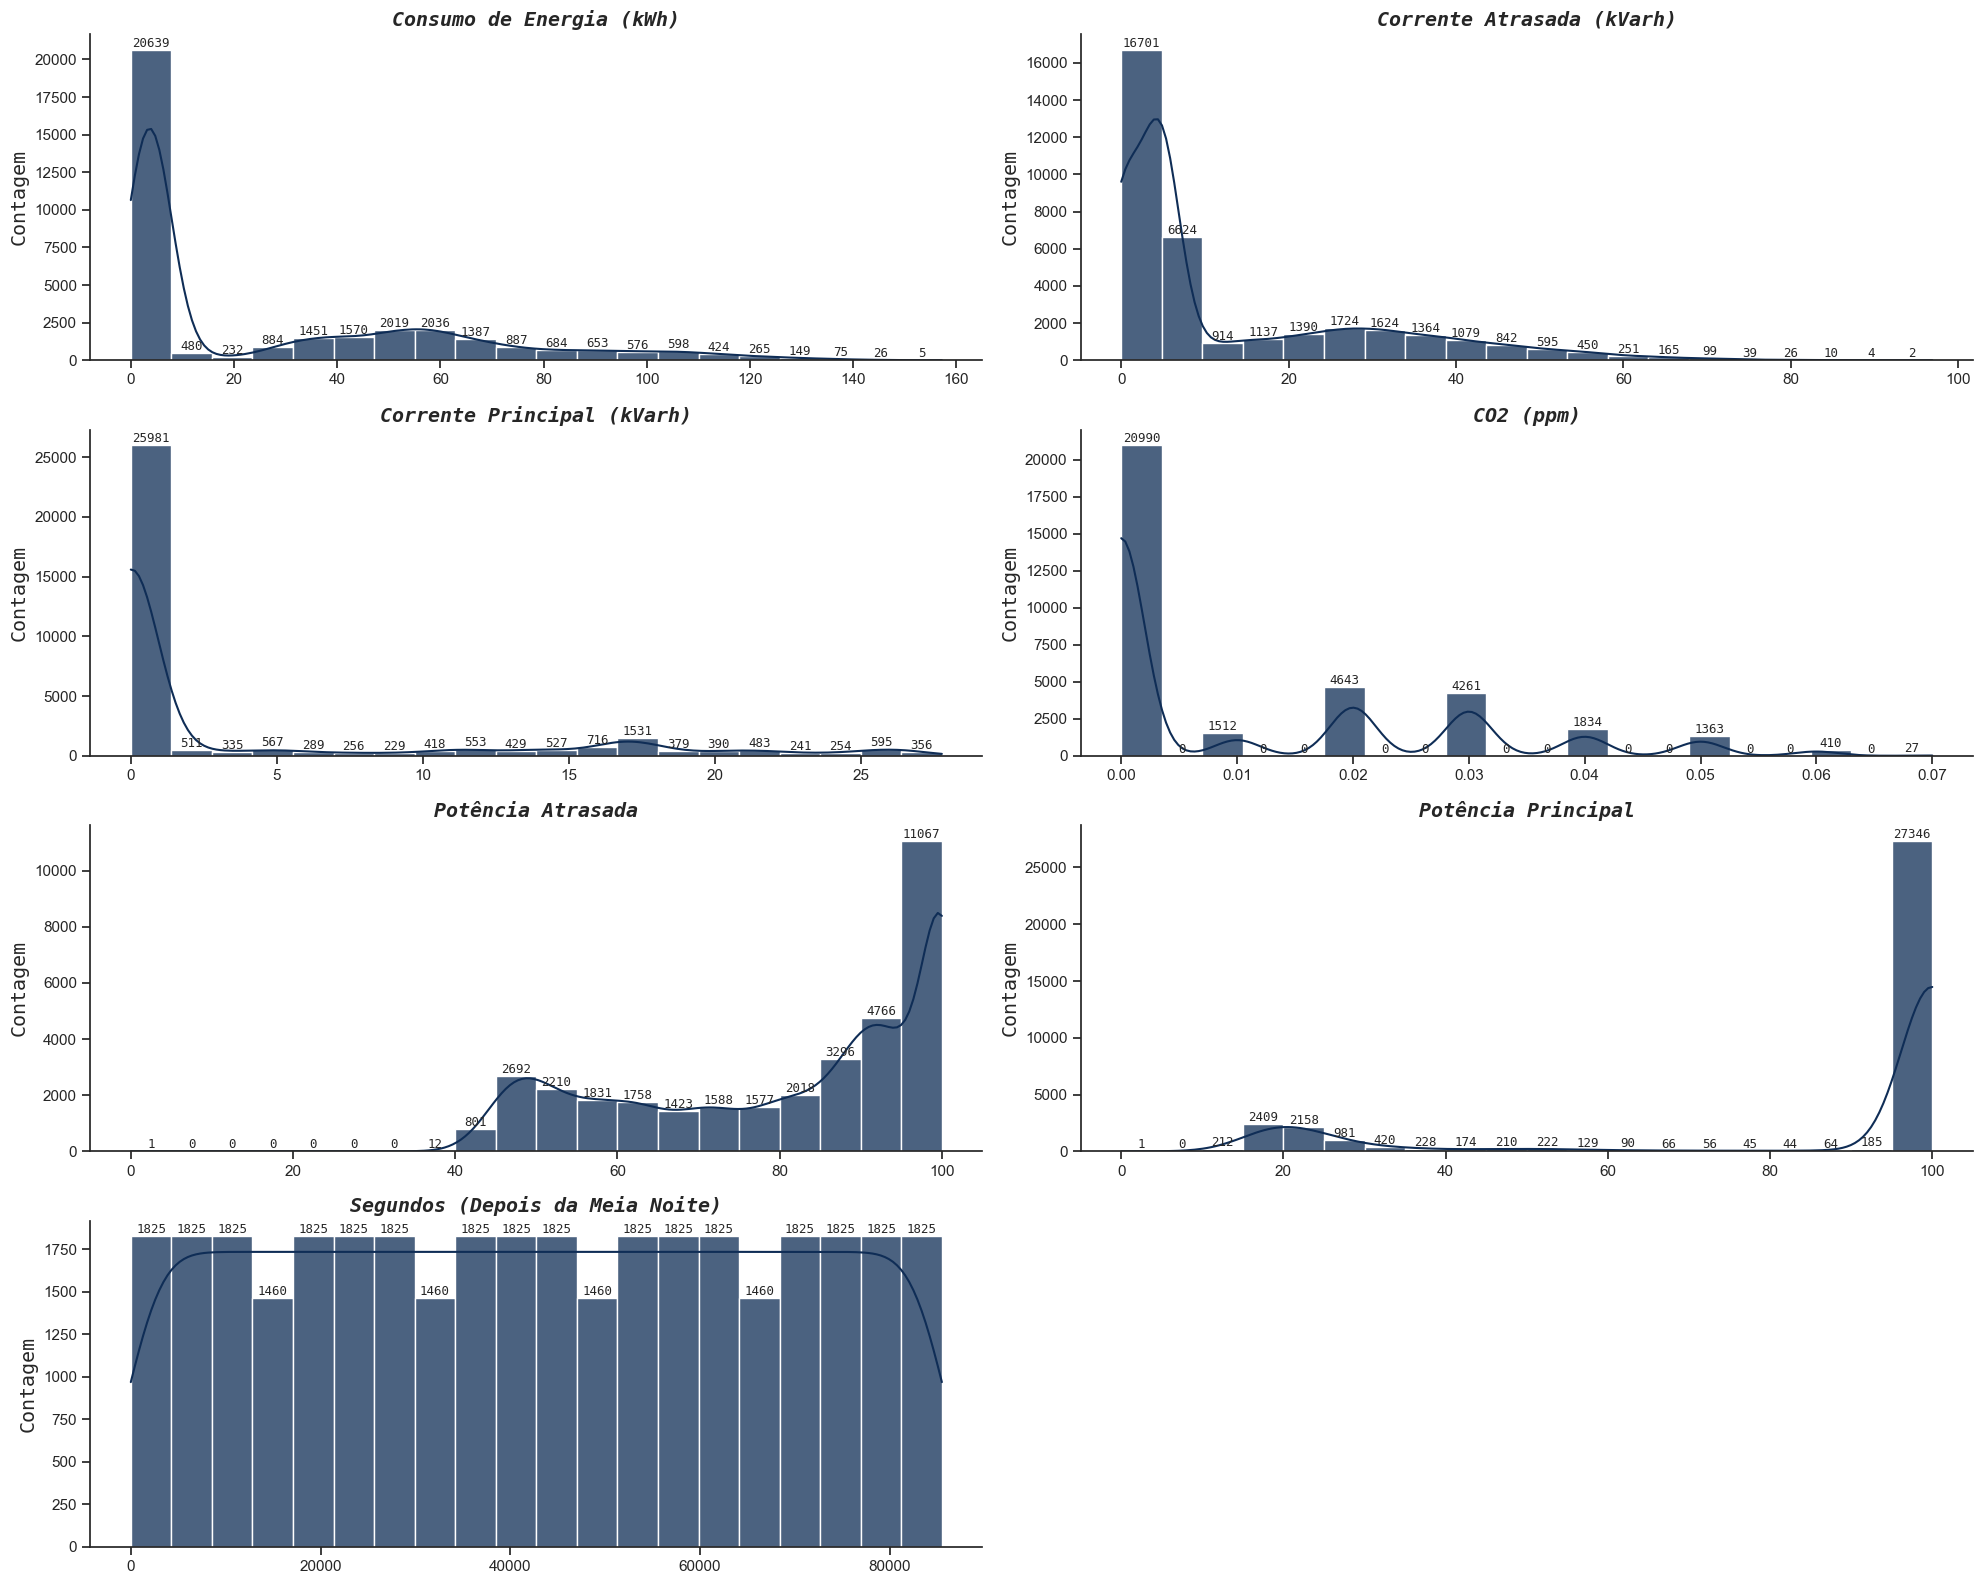

In [11]:
def plot_histograms(df: pd.DataFrame, columns: list, n_rows: int, n_cols: int, title: list):
    fig = plt.figure(figsize=(20, 16))
    for i, column in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.histplot(data=df, x=column, ax=ax, bins=20, kde=True, color='#0f2d56', alpha=.75)
        for value in ax.containers:
            ax.bar_label(value, label_type='edge', fontsize=9, family='monospace')
        ax.set_xlabel(None)
        ax.set_ylabel('Contagem', fontsize='large', family='monospace')
        ax.set_title(title[i], fontsize='large', fontweight='bold', style='italic', family='monospace')
    fig.tight_layout()
    
columns = df.drop(['data', 'estado_semana', 'dia_semana', 'tipo_carga', 'estacao'], axis=1).columns
title=['Consumo de Energia (kWh)', 'Corrente Atrasada (kVarh)', 'Corrente Principal (kVarh)', 'CO2 (ppm)', 'Potência Atrasada', 'Potência Principal', 'Segundos (Depois da Meia Noite)']
plot_histograms(df=df, columns=columns, n_rows=4, n_cols=2, title=title)
plt.show()

In [12]:
def create_bar(df_: pd, columns: list, n_rows: int, n_cols: int, rot=45):
    y_ = 'consumo_energia'
    fig = plt.figure(figsize=(20, 16))
    for i, column in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df = df_.groupby(by=column, as_index=False, sort=False)[y_].mean()
        try:
            df[column] = df[column].str.capitalize()
        except:
            pass
        
        sns.barplot(data=df, x=column, y=y_, palette=palette, ax=ax)
        for value in ax.containers:
            ax.bar_label(value)
        ax.tick_params(axis='x', labelrotation=rot, size=12)
        ax.tick_params(axis='y', size=12)
        ax.set_xlabel(column.capitalize(), fontsize='large', family='monospace')
        ax.set_ylabel("Consumo de Energia (kWh)", fontsize='large', family='monospace')
        ax.set_title(f"Média de Consumo de Energia por {column.capitalize()}", fontsize='large', fontweight='bold', 
                style='italic', family='monospace')
    fig.tight_layout()

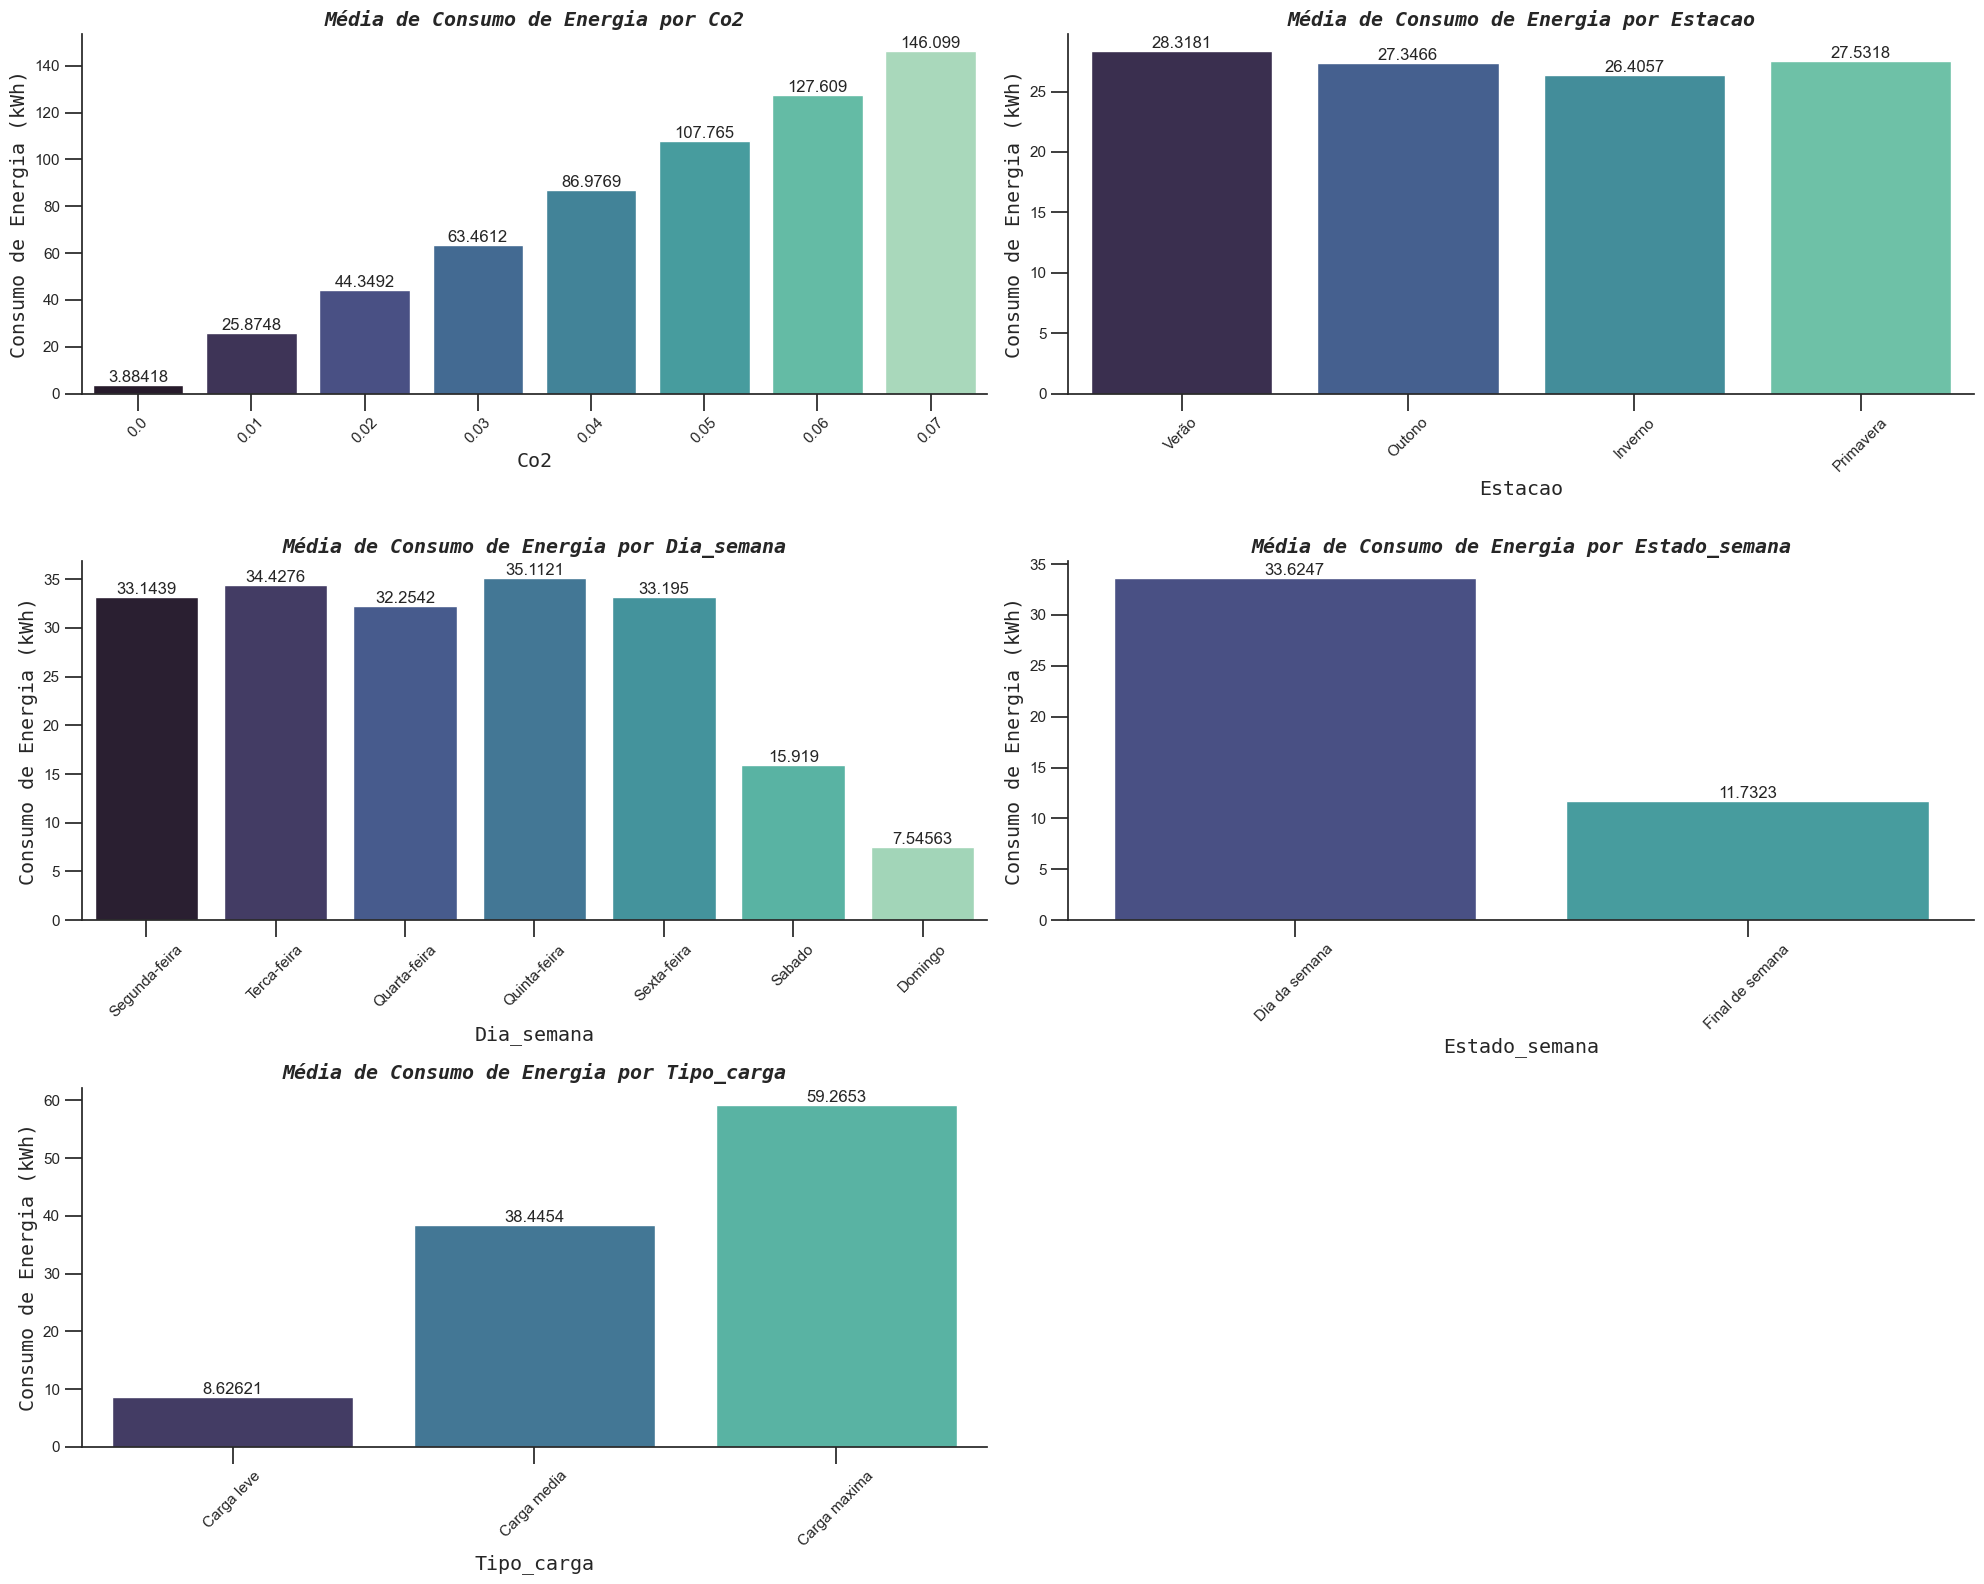

In [13]:
columns = ['co2', 'estacao', 'dia_semana', 'estado_semana', 'tipo_carga']
create_bar(df, columns, 3, 2)
plt.show()

In [14]:
def create_box_plot(df_: pd, columns: list, title: list, n_rows: int, n_cols: int):
    y_ = 'consumo_energia'
    fig = plt.figure(figsize=(20, 16))
    for i, column in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        
        sns.boxplot(data=df_, x=column, y=y_, ax=ax)
        ax.tick_params(axis='x', size=12)
        ax.tick_params(axis='y', size=12)
        ax.set_xlabel(column.capitalize(), fontsize='large', family='monospace')
        ax.set_ylabel("Consumo de Energia (kWh)", fontsize='large', family='monospace')
        ax.set_title(f"Boxplot de Consumo de Energia por title", fontsize='large', fontweight='bold', 
                style='italic', family='monospace')
    fig.tight_layout()

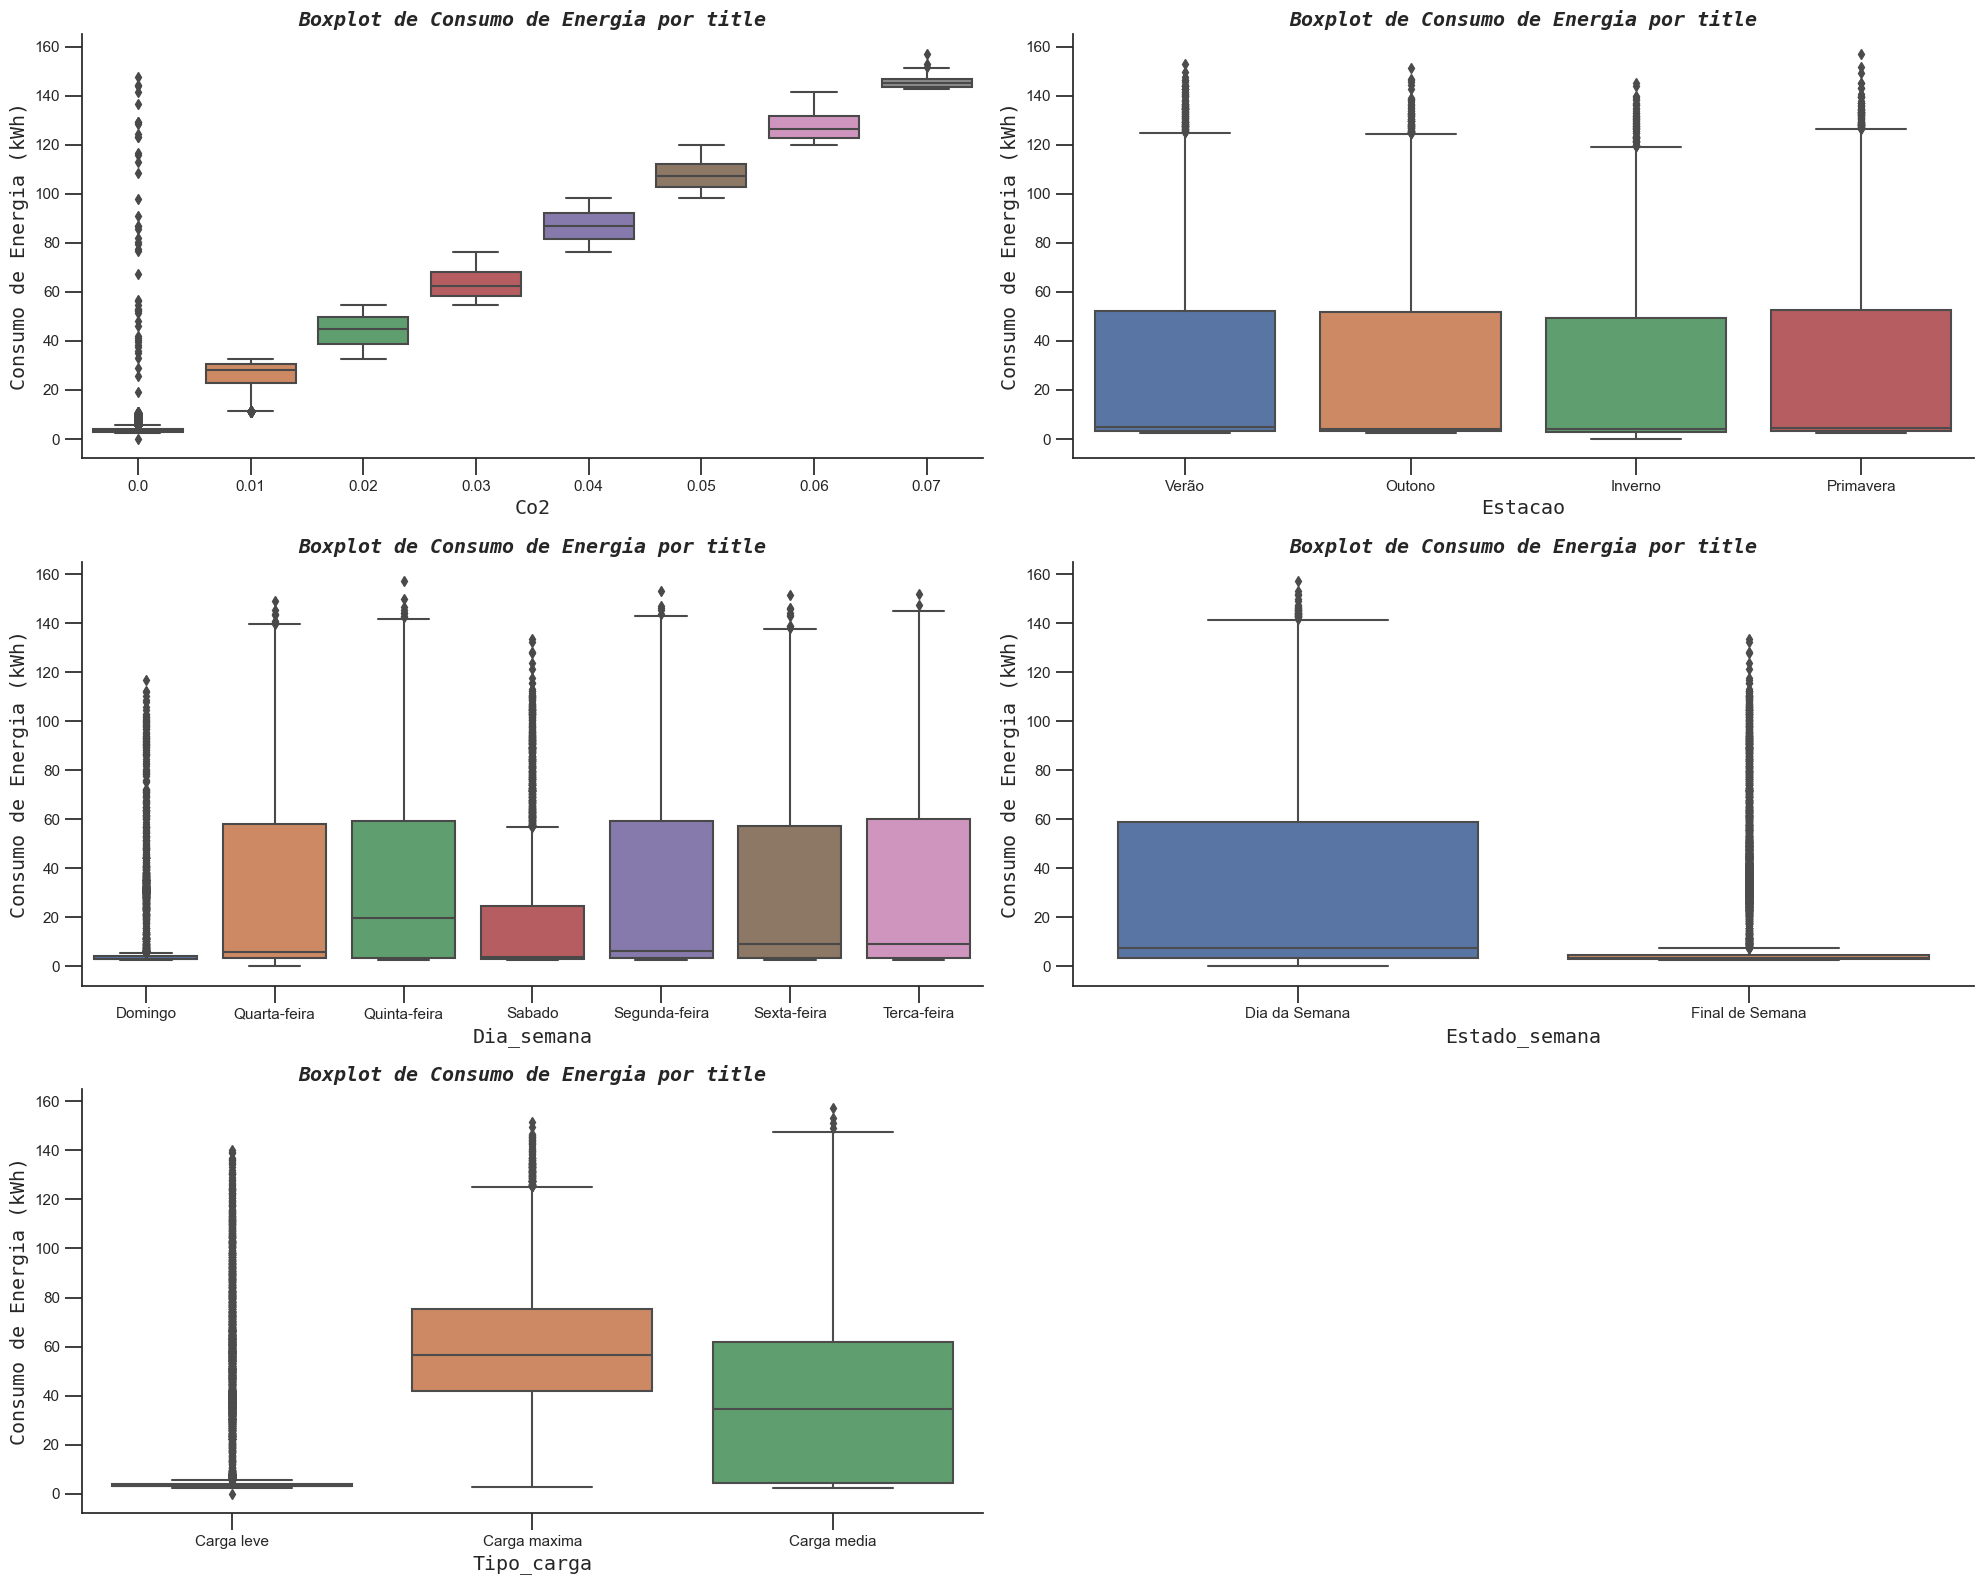

In [15]:
columns = ['co2', 'estacao', 'dia_semana', 'estado_semana', 'tipo_carga']
title = ['CO2 (ptm)', 'Estação', 'Dia da Semana', 'Estado da Semana', 'Tipo de Carga']
create_box_plot(df, columns, title, 3, 2)
plt.show()

In [16]:
def calculate_outliers(x: pd.Series) -> list:
    q1 = x.quantile(.25)
    q3 = x.quantile(.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return x[(x < lower_bound)].index.tolist(), x[(x > upper_bound)].index.tolist()

for column in df.drop(['data', 'estado_semana', 'dia_semana', 'tipo_carga', 'estacao'], axis=1).columns:
    lower, upper = calculate_outliers(df[column])
    column = column.replace('_', ' ')
    column = column.capitalize()
    print(f"{column}: Lower = {len(lower)}, Upper = {len(upper)}, Total = {len(lower) + len(upper)}")
    
del calculate_outliers

Consumo energia: Lower = 0, Upper = 328, Total = 328
Corrente atrasada: Lower = 0, Upper = 1059, Total = 1059
Corrente principal: Lower = 0, Upper = 7759, Total = 7759
Co2: Lower = 0, Upper = 1800, Total = 1800
Potência atrasado: Lower = 1, Upper = 0, Total = 1
Potência principal: Lower = 8327, Upper = 0, Total = 8327
Segundos depois meia noite: Lower = 0, Upper = 0, Total = 0


In [17]:
def calculate_amplitude(x: pd.Series) -> float:
    return x.max() - x.min()

for column in df.drop(['data', 'estado_semana', 'dia_semana', 'tipo_carga', 'estacao'], axis=1).columns:
    amplitude = calculate_amplitude(df[column])
    column = column.replace('_', ' ')
    column = column.capitalize()
    print(f"{column}: Amplitude = {amplitude:.2f}")
    
del calculate_amplitude

Consumo energia: Amplitude = 157.18
Corrente atrasada: Amplitude = 96.91
Corrente principal: Amplitude = 27.76
Co2: Amplitude = 0.07
Potência atrasado: Amplitude = 100.00
Potência principal: Amplitude = 100.00
Segundos depois meia noite: Amplitude = 85500.00


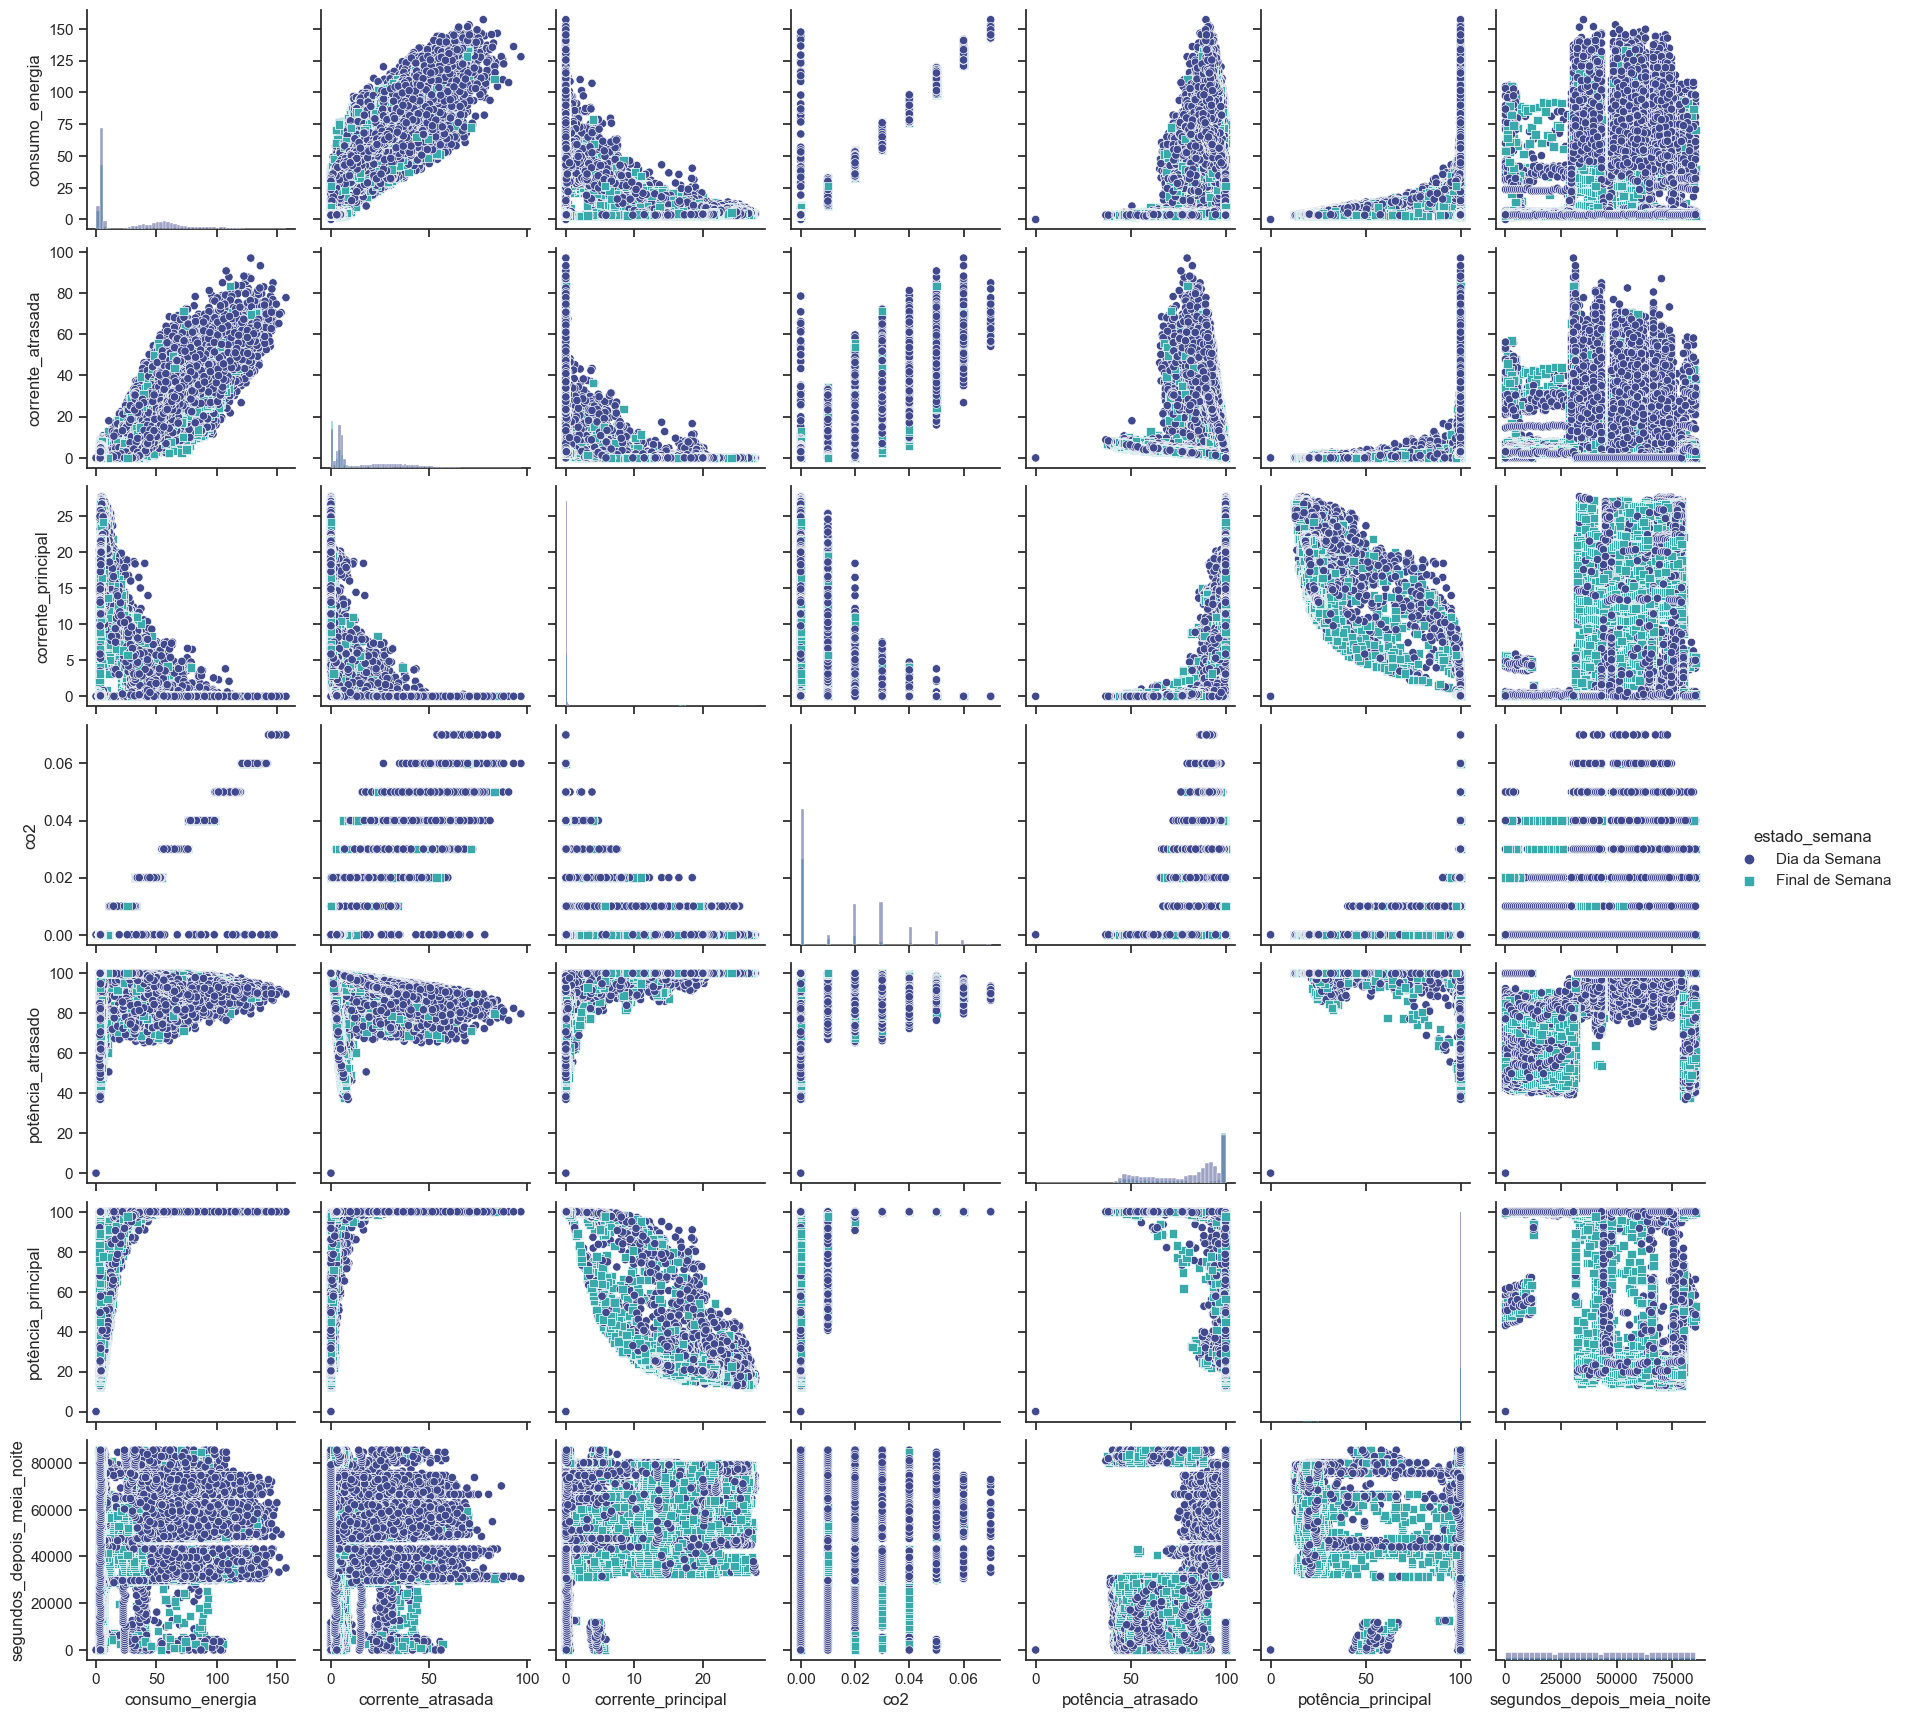

In [18]:
sns.pairplot(df, hue="estado_semana", palette=palette, markers=["o", "s"], diag_kind="hist")
plt.show()

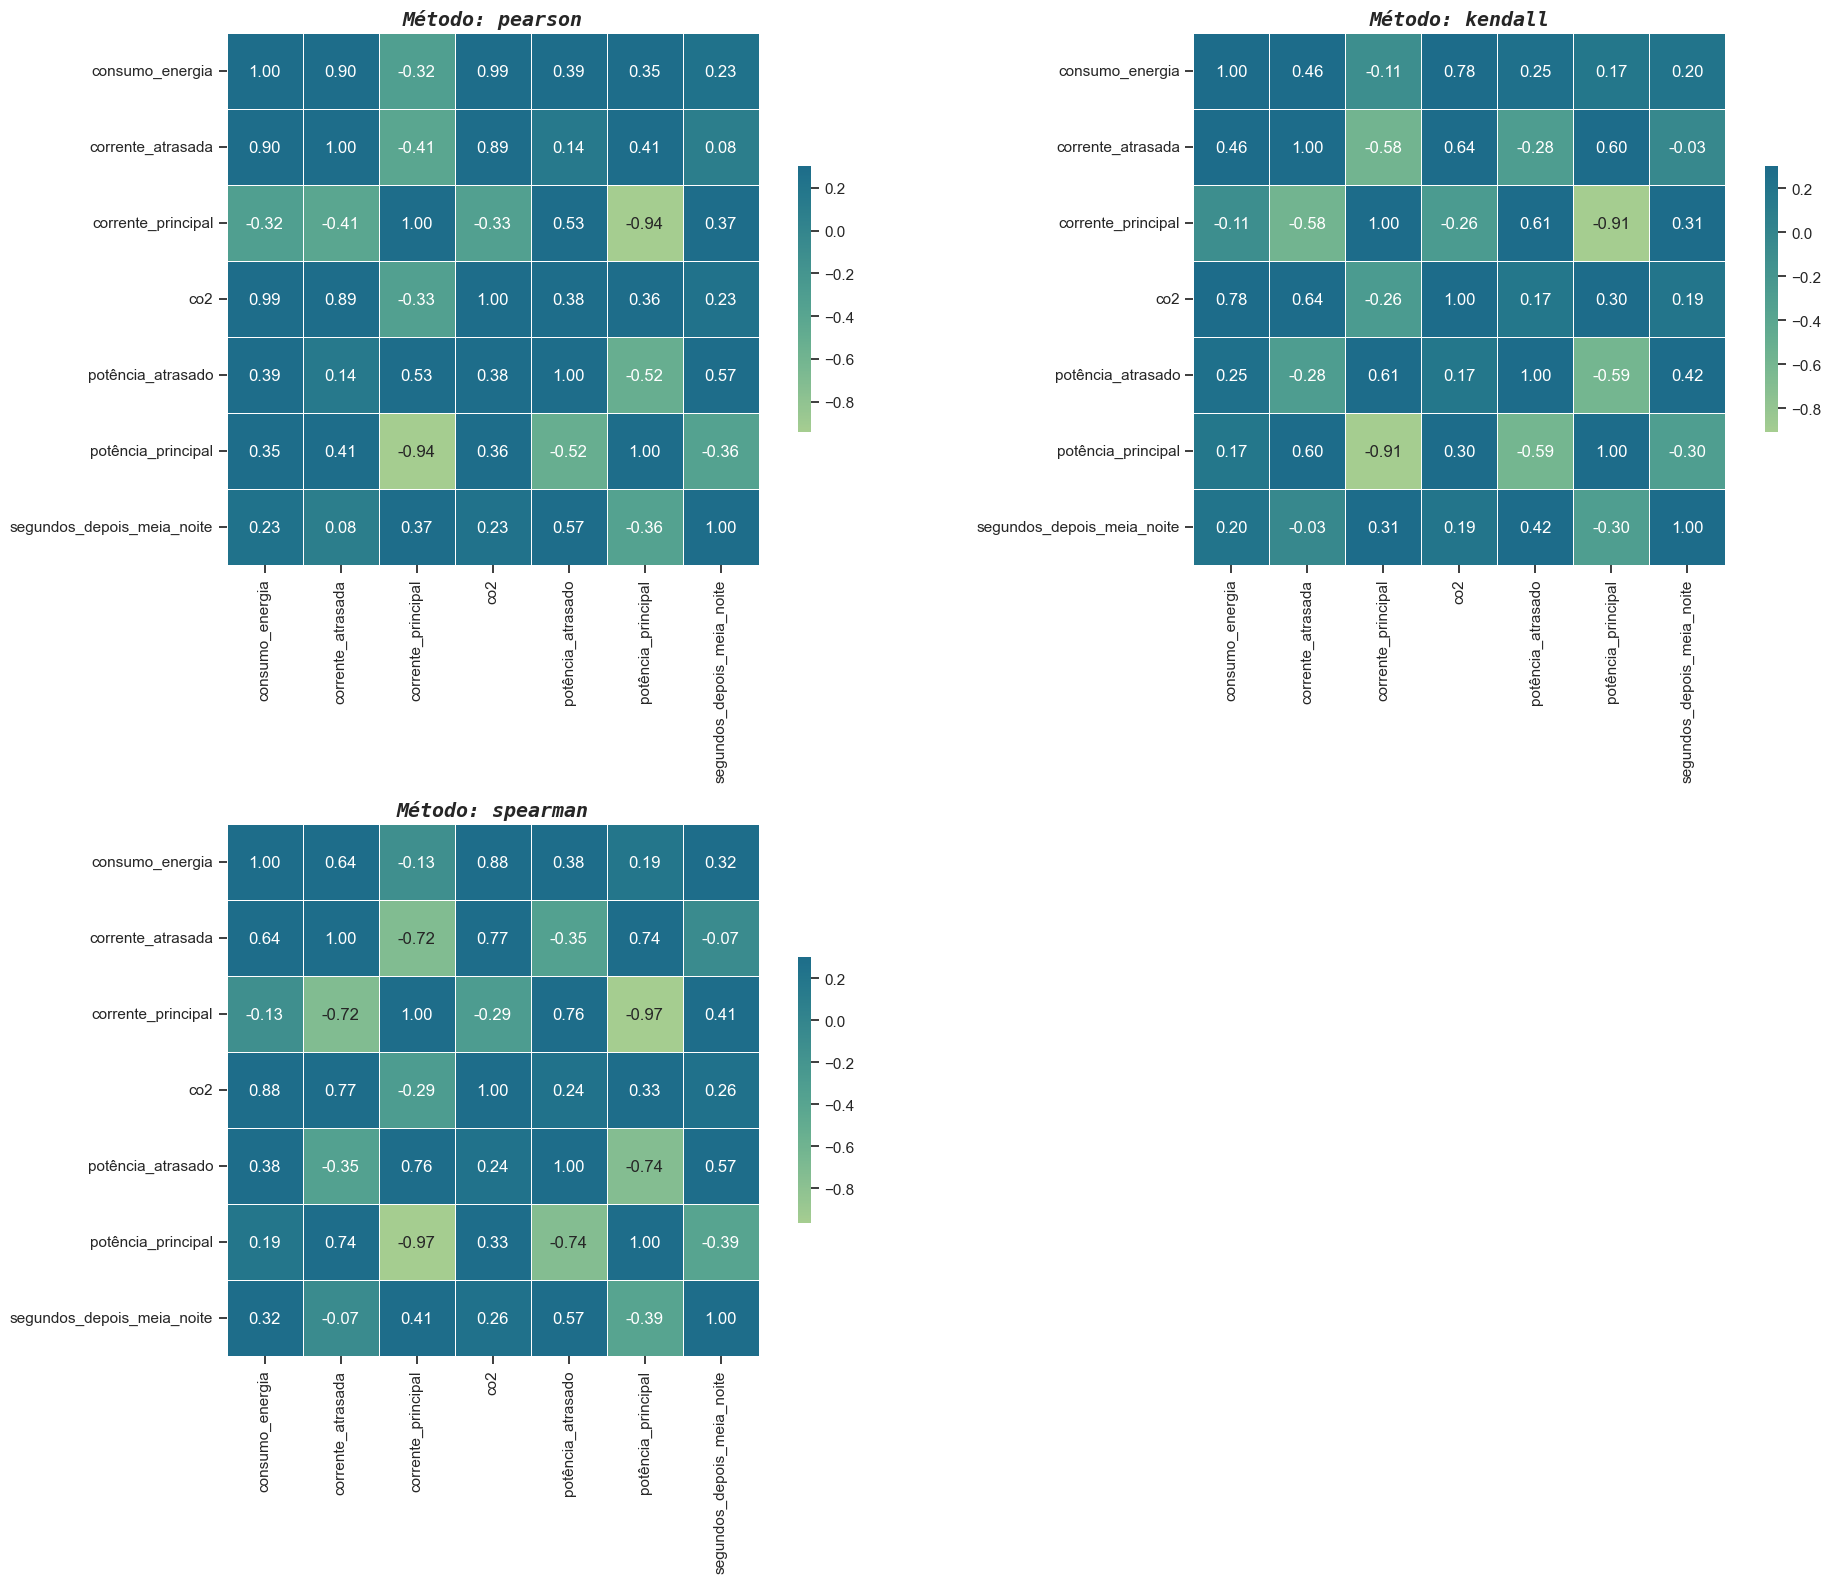

In [19]:
fig = plt.figure(figsize=(20, 16))
for i, method in enumerate(['pearson', 'kendall', 'spearman']):
    ax = fig.add_subplot(2, 2, i + 1)
    corr = df.corr(numeric_only=True, method=method)
    sns.heatmap(corr, cmap="crest", vmax=.3, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', ax=ax)
    ax.set_title(f'Método: {method}', fontsize='large', fontweight='bold', style='italic', family='monospace')
    
fig.tight_layout()

plt.show()

In [37]:
df_groupby_day = df.set_index('data').resample('D').agg(
    {
        'consumo_energia': 'sum',
        'corrente_atrasada': 'sum',
        'corrente_principal': 'sum',
        'co2': 'mean',
        'potência_atrasado': 'mean',
        'potência_principal': 'mean',
        'segundos_depois_meia_noite': 'mean',
        'estado_semana': lambda x: x.mode()[0],
        'dia_semana': lambda x: x.mode()[0],
        'tipo_carga': lambda x: x.mode()[0],
        'estacao': lambda x: x.mode()[0],
    }
).copy()

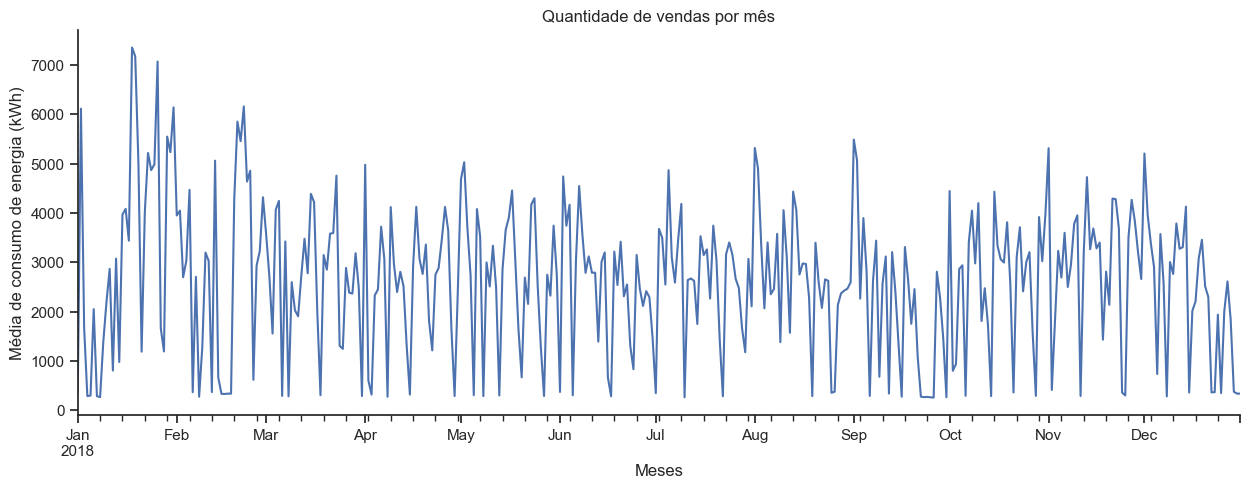

In [38]:
plt.figure(figsize=(15, 5))

df_groupby_day['consumo_energia'].plot()
plt.xlabel('Meses')
plt.ylabel('Média de consumo de energia (kWh)')
plt.title('Quantidade de vendas por mês')
plt.show()

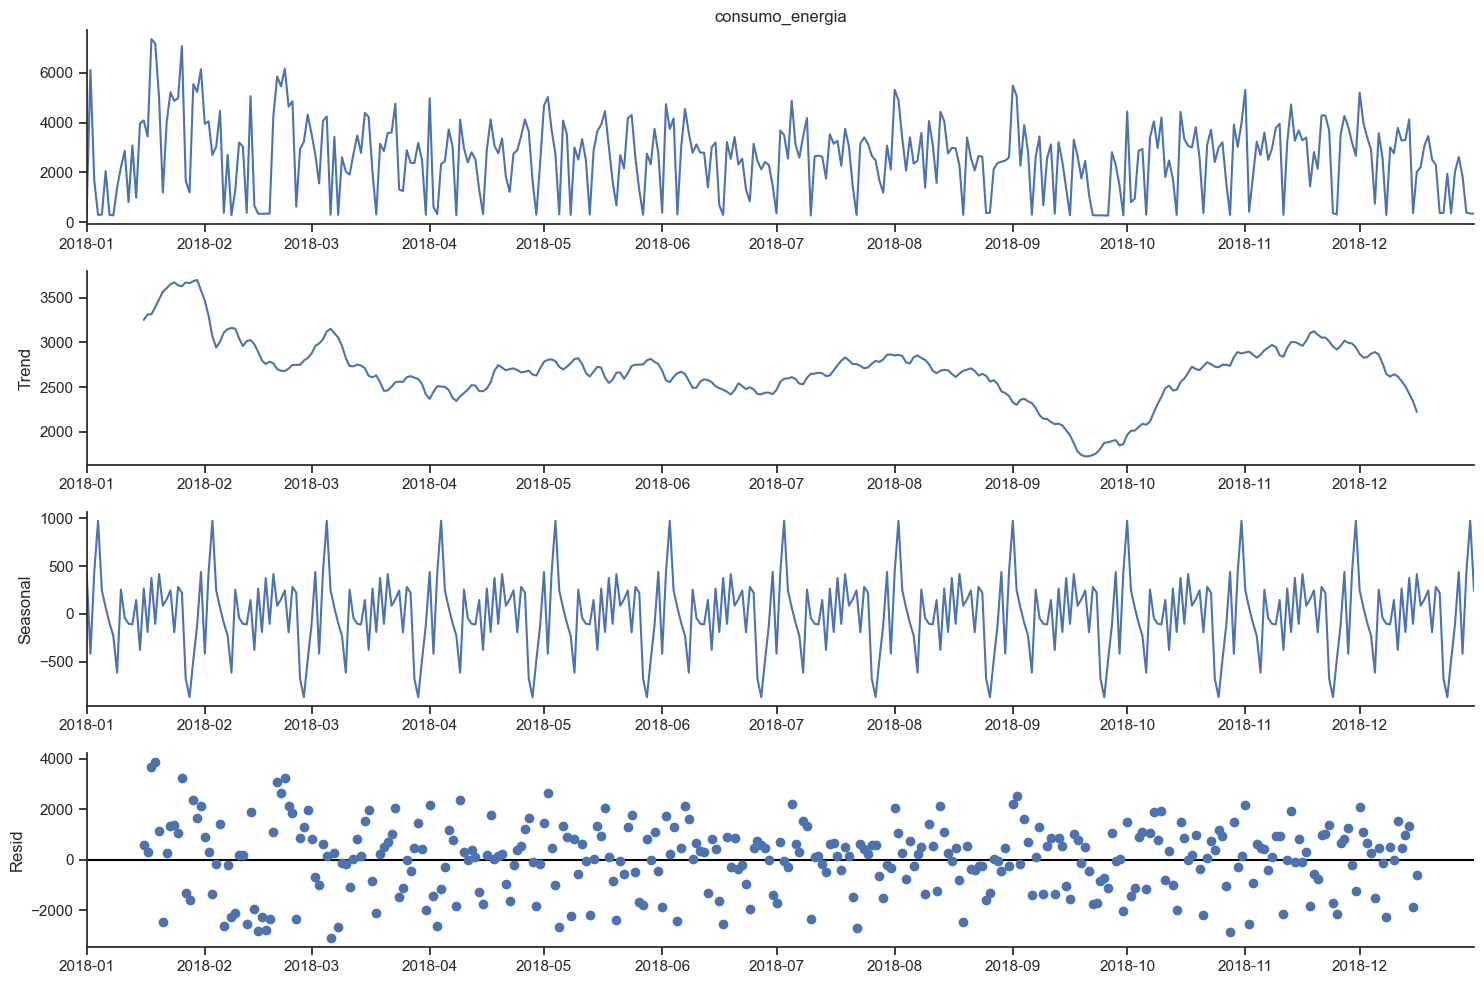

In [42]:
decomposed = seasonal_decompose(df_groupby_day['consumo_energia'], model='additive', period=30)

fig = decomposed.plot()
fig.set_size_inches((15, 10))
fig.tight_layout()
plt.show()
